## Folk from https://github.com/czimaginginstitute/2024_czii_mlchallenge_notebooks
3D Unet MONAI

In [1]:
!pip install git+https://github.com/copick/copick-utils.git matplotlib tqdm copick 
!pip install -q "monai-weekly[mlflow]"

  Cloning https://github.com/copick/copick-utils.git to /tmp/pip-req-build-xzhikf00
  Running command git clone --filter=blob:none --quiet https://github.com/copick/copick-utils.git /tmp/pip-req-build-xzhikf00
  Resolved https://github.com/copick/copick-utils.git to commit 8936b5b9379bf4f58d49ac58a9669076baeeff5b
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... - done
INFO: pip is looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of boto3 to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for gu

In [2]:
# Make a copick project
import os
import shutil

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "/kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/kaggle/input/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = "/kaggle/working/copick.config"
output_overlay = "/kaggle/working/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = '/kaggle/input/czii-cryo-et-object-identification/train/overlay'
destination_dir = '/kaggle/working/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")


Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/beta-amylase.json to /kaggle/working/overlay/ExperimentRuns/TS_86_3/Picks/curation_0_beta-amylase.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/beta-galactosidase.json to /kaggle/working/overlay/ExperimentRuns/TS_86_3/Picks/curation_0_beta-galactosidase.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/apo-ferritin.json to /kaggle/working/overlay/ExperimentRuns/TS_86_3/Picks/curation_0_apo-ferritin.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/virus-like-particle.json to /kaggle/working/overlay/ExperimentRuns/TS_86_3/Picks/curation_0_virus-like-particle.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/ribosome.json to /kaggle/working/overlay/ExperimentRuns/TS_86_3/Pic

In [3]:
import os
import numpy as np
from pathlib import Path
import torch
import torchinfo
import zarr, copick
from tqdm import tqdm
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric
import mlflow
import mlflow.pytorch

## prepare the dataset

1. Get copick root

In [4]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

/tmp/ipykernel_23/1739253755.py:1: DeprecationWarning: config_type not found in config file, defaulting to filesystem
  root = copick.from_file(copick_config_path)


2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [5]:
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict

# Just do this once
generate_masks = True

if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(10)
        tomo = tomo.get_tomogram(tomo_type).numpy()
        target = np.zeros(tomo.shape, dtype=np.uint8)
        for pickable_object in root.pickable_objects:
            pick = run.get_picks(object_name=pickable_object.name, user_id="curation")
            if len(pick):  
                target = segmentation_from_picks.from_picks(pick[0], 
                                                            target, 
                                                            target_objects[pickable_object.name]['radius'] * 0.8,
                                                            target_objects[pickable_object.name]['label']
                                                            )
        write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)
        

100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


3. Get tomograms and their segmentaion masks (from picks) arrays

This 10439 dataset contains 27 tomograms. We will use the first 5 tomograms for training, and the following 2 tomograms for validation. Therefore, we will get the first 7 tomograms from the cryoET data portal in this notebook, and we will use the rest 20 tomograms for inference in a different notebook.

In [6]:
data_dicts = []
for run in tqdm(root.runs):
    tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()
    segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
    data_dicts.append({"image": tomogram, "label": segmentation})
    
print(np.unique(data_dicts[0]['label']))

100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


[0 1 3 4 5 6]



4. Visualize the tomogram and painted segmentation from ground-truth picks

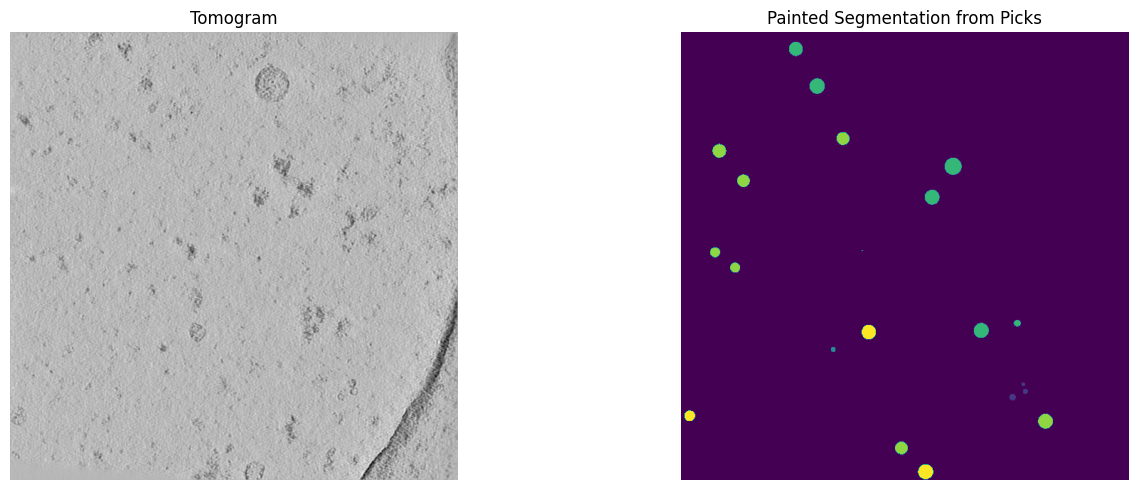

In [7]:
import matplotlib.pyplot as plt

# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][100],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][100], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()


5. Prepare dataloaders

In [8]:
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1

train_files, val_files = data_dicts[:5], data_dicts[5:7]
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Validation transforms
val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
    ),
])

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
val_ds = Dataset(data=val_ds, transform=random_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=4,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

Number of training samples: 5
Number of validation samples: 2


Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


## Model setup

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")


cuda


In [10]:
post_pred = AsDiscrete(argmax=True, to_onehot=len(root.pickable_objects)+1)
post_label = AsDiscrete(to_onehot=len(root.pickable_objects)+1)

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=100):
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_inputs)
                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    
                    
                    # compute metric for current iteration
                    metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                metrics = metrics_function.aggregate(reduction="mean_batch")
                metric_per_class = ["{:.4g}".format(x) for x in metrics]
                metric = torch.mean(metrics).numpy(force=True)
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                for i,m in enumerate(metrics):
                    mlflow.log_metric(f"validation metric class {i+1}", m, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean recall per class: {', '.join(metric_per_class)}"
                    f"\nbest mean recall: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

## Training and tracking

In [11]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 200
with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

2024/11/08 05:29:58 INFO mlflow.tracking.fluent: Experiment with name 'training 3D U-Net model for the cryoET ML Challenge' does not exist. Creating a new experiment.


----------
epoch 1/200


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio 

batch 1/5, train_loss: 0.9682
batch 2/5, train_loss: 0.9624
batch 3/5, train_loss: 0.9557
batch 4/5, train_loss: 0.9548
batch 5/5, train_loss: 0.9442
epoch 1 average loss: 0.9571
----------
epoch 2/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.9433
batch 2/5, train_loss: 0.9350
batch 3/5, train_loss: 0.9360
batch 4/5, train_loss: 0.9285
batch 5/5, train_loss: 0.9247
epoch 2 average loss: 0.9335


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 2 current mean recall per class: 0.0003772, 0, 0.0008365, 0.1714, 0.01979, 0.0479, 0
best mean recall: 0.0343 at epoch: 2
----------
epoch 3/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.9220
batch 2/5, train_loss: 0.9212
batch 3/5, train_loss: 0.9165
batch 4/5, train_loss: 0.9089
batch 5/5, train_loss: 0.9114
epoch 3 average loss: 0.9160
----------
epoch 4/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.9009
batch 2/5, train_loss: 0.9033
batch 3/5, train_loss: 0.9027
batch 4/5, train_loss: 0.8906
batch 5/5, train_loss: 0.8950
epoch 4 average loss: 0.8985


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 4 current mean recall per class: 0.0006203, 0, 0.001789, 0.3667, 0.01954, 0.0447, 0
best mean recall: 0.0619 at epoch: 4
----------
epoch 5/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8955
batch 2/5, train_loss: 0.8849
batch 3/5, train_loss: 0.8857
batch 4/5, train_loss: 0.8848
batch 5/5, train_loss: 0.8901
epoch 5 average loss: 0.8882
----------
epoch 6/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8761
batch 2/5, train_loss: 0.8770
batch 3/5, train_loss: 0.8737
batch 4/5, train_loss: 0.8797
batch 5/5, train_loss: 0.8861
epoch 6 average loss: 0.8785


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 6 current mean recall per class: 0.0004582, 0, 0.004828, 0.4388, 0.03121, 0.1099, 0
best mean recall: 0.0836 at epoch: 6
----------
epoch 7/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8804
batch 2/5, train_loss: 0.8669
batch 3/5, train_loss: 0.8722
batch 4/5, train_loss: 0.8632
batch 5/5, train_loss: 0.8637
epoch 7 average loss: 0.8693
----------
epoch 8/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8588
batch 2/5, train_loss: 0.8730
batch 3/5, train_loss: 0.8610
batch 4/5, train_loss: 0.8515
batch 5/5, train_loss: 0.8539
epoch 8 average loss: 0.8596


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 8 current mean recall per class: 0.0004907, 0, 0.01066, 0.4673, 0.06256, 0.1888, 0
best mean recall: 0.1043 at epoch: 8
----------
epoch 9/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8540
batch 2/5, train_loss: 0.8718
batch 3/5, train_loss: 0.8543
batch 4/5, train_loss: 0.8646
batch 5/5, train_loss: 0.8606
epoch 9 average loss: 0.8610
----------
epoch 10/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8638
batch 2/5, train_loss: 0.8543
batch 3/5, train_loss: 0.8622
batch 4/5, train_loss: 0.8479
batch 5/5, train_loss: 0.8588
epoch 10 average loss: 0.8574


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 10 current mean recall per class: 0.0009733, 0, 0.01023, 0.4401, 0.08254, 0.2083, 0
best mean recall: 0.1060 at epoch: 10
----------
epoch 11/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8519
batch 2/5, train_loss: 0.8573
batch 3/5, train_loss: 0.8438
batch 4/5, train_loss: 0.8663
batch 5/5, train_loss: 0.8500
epoch 11 average loss: 0.8539
----------
epoch 12/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8444
batch 2/5, train_loss: 0.8485
batch 3/5, train_loss: 0.8511
batch 4/5, train_loss: 0.8596
batch 5/5, train_loss: 0.8368
epoch 12 average loss: 0.8481


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 12 current mean recall per class: 0.0005003, 0, 0.001887, 0.3539, 0.07906, 0.2654, 0
best mean recall: 0.1060 at epoch: 10
----------
epoch 13/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8488
batch 2/5, train_loss: 0.8398
batch 3/5, train_loss: 0.8456
batch 4/5, train_loss: 0.8447
batch 5/5, train_loss: 0.8397
epoch 13 average loss: 0.8437
----------
epoch 14/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8510
batch 2/5, train_loss: 0.8390
batch 3/5, train_loss: 0.8395
batch 4/5, train_loss: 0.8520
batch 5/5, train_loss: 0.8318
epoch 14 average loss: 0.8427


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 14 current mean recall per class: 0.00178, 0, 0.0005126, 0.4927, 0.08727, 0.2628, 0
best mean recall: 0.1207 at epoch: 14
----------
epoch 15/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8456
batch 2/5, train_loss: 0.8286
batch 3/5, train_loss: 0.8479
batch 4/5, train_loss: 0.8259
batch 5/5, train_loss: 0.8377
epoch 15 average loss: 0.8371
----------
epoch 16/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8519
batch 2/5, train_loss: 0.8542
batch 3/5, train_loss: 0.8343
batch 4/5, train_loss: 0.8325
batch 5/5, train_loss: 0.8171
epoch 16 average loss: 0.8380


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 16 current mean recall per class: 0.0009077, 0, 7.335e-05, 0.4223, 0.09047, 0.6336, 0
best mean recall: 0.1639 at epoch: 16
----------
epoch 17/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8590
batch 2/5, train_loss: 0.8237
batch 3/5, train_loss: 0.8335
batch 4/5, train_loss: 0.8303
batch 5/5, train_loss: 0.8473
epoch 17 average loss: 0.8388
----------
epoch 18/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8203
batch 2/5, train_loss: 0.8085
batch 3/5, train_loss: 0.8350
batch 4/5, train_loss: 0.8389
batch 5/5, train_loss: 0.8226
epoch 18 average loss: 0.8251


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 18 current mean recall per class: 0.0003468, 0, 0, 0.394, 0.09495, 0.4004, 0
best mean recall: 0.1639 at epoch: 16
----------
epoch 19/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8083
batch 2/5, train_loss: 0.8177
batch 3/5, train_loss: 0.8233
batch 4/5, train_loss: 0.8192
batch 5/5, train_loss: 0.8084
epoch 19 average loss: 0.8154
----------
epoch 20/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8186
batch 2/5, train_loss: 0.8516
batch 3/5, train_loss: 0.8185
batch 4/5, train_loss: 0.8239
batch 5/5, train_loss: 0.8057
epoch 20 average loss: 0.8237


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 20 current mean recall per class: 0, 0, 0, 0.4577, 0.06779, 0.2896, 0
best mean recall: 0.1639 at epoch: 16
----------
epoch 21/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8219
batch 2/5, train_loss: 0.8124
batch 3/5, train_loss: 0.8089
batch 4/5, train_loss: 0.8236
batch 5/5, train_loss: 0.7863
epoch 21 average loss: 0.8106
----------
epoch 22/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8168
batch 2/5, train_loss: 0.8173
batch 3/5, train_loss: 0.8112
batch 4/5, train_loss: 0.8162
batch 5/5, train_loss: 0.8099
epoch 22 average loss: 0.8143


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 22 current mean recall per class: 0, 0, 0, 0.4527, 0.1114, 0.4883, 0
best mean recall: 0.1639 at epoch: 16
----------
epoch 23/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8040
batch 2/5, train_loss: 0.8233
batch 3/5, train_loss: 0.8322
batch 4/5, train_loss: 0.8204
batch 5/5, train_loss: 0.8164
epoch 23 average loss: 0.8193
----------
epoch 24/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8158
batch 2/5, train_loss: 0.8103
batch 3/5, train_loss: 0.8123
batch 4/5, train_loss: 0.7924
batch 5/5, train_loss: 0.8166
epoch 24 average loss: 0.8095


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 24 current mean recall per class: 0, 0, 0, 0.6003, 0.1098, 0.5172, 0
best mean recall: 0.1753 at epoch: 24
----------
epoch 25/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7976
batch 2/5, train_loss: 0.8083
batch 3/5, train_loss: 0.8172
batch 4/5, train_loss: 0.8397
batch 5/5, train_loss: 0.8086
epoch 25 average loss: 0.8143
----------
epoch 26/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8110
batch 2/5, train_loss: 0.8401
batch 3/5, train_loss: 0.8213
batch 4/5, train_loss: 0.8232
batch 5/5, train_loss: 0.8207
epoch 26 average loss: 0.8233


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 26 current mean recall per class: 0.0001274, 0, 0, 0.3768, 0.1962, 0.6374, 0
best mean recall: 0.1753 at epoch: 24
----------
epoch 27/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7942
batch 2/5, train_loss: 0.8088
batch 3/5, train_loss: 0.8073
batch 4/5, train_loss: 0.8165
batch 5/5, train_loss: 0.8174
epoch 27 average loss: 0.8088
----------
epoch 28/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8119
batch 2/5, train_loss: 0.8362
batch 3/5, train_loss: 0.8074
batch 4/5, train_loss: 0.8052
batch 5/5, train_loss: 0.8057
epoch 28 average loss: 0.8133


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 28 current mean recall per class: 0.001601, 0, 6.88e-05, 0.4529, 0.2021, 0.5673, 0
best mean recall: 0.1753 at epoch: 24
----------
epoch 29/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7963
batch 2/5, train_loss: 0.8286
batch 3/5, train_loss: 0.7865
batch 4/5, train_loss: 0.8028
batch 5/5, train_loss: 0.8143
epoch 29 average loss: 0.8057
----------
epoch 30/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7870
batch 2/5, train_loss: 0.7930
batch 3/5, train_loss: 0.8082
batch 4/5, train_loss: 0.7733
batch 5/5, train_loss: 0.7938
epoch 30 average loss: 0.7911


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 30 current mean recall per class: 0.01246, 0, 0.005747, 0.3822, 0.2426, 0.675, 0
best mean recall: 0.1883 at epoch: 30
----------
epoch 31/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7926
batch 2/5, train_loss: 0.7897
batch 3/5, train_loss: 0.7988
batch 4/5, train_loss: 0.7867
batch 5/5, train_loss: 0.7809
epoch 31 average loss: 0.7897
----------
epoch 32/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7993
batch 2/5, train_loss: 0.8001
batch 3/5, train_loss: 0.8049
batch 4/5, train_loss: 0.8117
batch 5/5, train_loss: 0.7769
epoch 32 average loss: 0.7986


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 32 current mean recall per class: 0.01908, 0, 0.007692, 0.4696, 0.2756, 0.6226, 0
best mean recall: 0.1992 at epoch: 32
----------
epoch 33/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7638
batch 2/5, train_loss: 0.7896
batch 3/5, train_loss: 0.7777
batch 4/5, train_loss: 0.7940
batch 5/5, train_loss: 0.7934
epoch 33 average loss: 0.7837
----------
epoch 34/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7920
batch 2/5, train_loss: 0.7924
batch 3/5, train_loss: 0.7839
batch 4/5, train_loss: 0.7800
batch 5/5, train_loss: 0.8138
epoch 34 average loss: 0.7924


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 34 current mean recall per class: 0.03842, 0, 0.06296, 0.4802, 0.2302, 0.5968, 0
best mean recall: 0.2012 at epoch: 34
----------
epoch 35/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8080
batch 2/5, train_loss: 0.7823
batch 3/5, train_loss: 0.7705
batch 4/5, train_loss: 0.7401
batch 5/5, train_loss: 0.8071
epoch 35 average loss: 0.7816
----------
epoch 36/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7858
batch 2/5, train_loss: 0.7709
batch 3/5, train_loss: 0.7904
batch 4/5, train_loss: 0.7828
batch 5/5, train_loss: 0.7856
epoch 36 average loss: 0.7831


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 36 current mean recall per class: 0.06391, 0, 0.08888, 0.6044, 0.2461, 0.5746, 0
best mean recall: 0.2254 at epoch: 36
----------
epoch 37/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.8021
batch 2/5, train_loss: 0.7540
batch 3/5, train_loss: 0.7775
batch 4/5, train_loss: 0.7657
batch 5/5, train_loss: 0.7749
epoch 37 average loss: 0.7749
----------
epoch 38/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7693
batch 2/5, train_loss: 0.7642
batch 3/5, train_loss: 0.7691
batch 4/5, train_loss: 0.7614
batch 5/5, train_loss: 0.7760
epoch 38 average loss: 0.7680


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 38 current mean recall per class: 0.08039, 0, 0.118, 0.5136, 0.2385, 0.5525, 0
best mean recall: 0.2254 at epoch: 36
----------
epoch 39/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7784
batch 2/5, train_loss: 0.7848
batch 3/5, train_loss: 0.7727
batch 4/5, train_loss: 0.7872
batch 5/5, train_loss: 0.7562
epoch 39 average loss: 0.7758
----------
epoch 40/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7549
batch 2/5, train_loss: 0.7835
batch 3/5, train_loss: 0.7488
batch 4/5, train_loss: 0.7657
batch 5/5, train_loss: 0.7813
epoch 40 average loss: 0.7668


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 40 current mean recall per class: 0.1181, 0, 0.1309, 0.5532, 0.252, 0.5818, 0
best mean recall: 0.2337 at epoch: 40
----------
epoch 41/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7980
batch 2/5, train_loss: 0.7971
batch 3/5, train_loss: 0.7867
batch 4/5, train_loss: 0.7868
batch 5/5, train_loss: 0.7689
epoch 41 average loss: 0.7875
----------
epoch 42/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7742
batch 2/5, train_loss: 0.7736
batch 3/5, train_loss: 0.7714
batch 4/5, train_loss: 0.7774
batch 5/5, train_loss: 0.7598
epoch 42 average loss: 0.7713


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 42 current mean recall per class: 0.1091, 0, 0.1594, 0.5876, 0.2457, 0.646, 0
best mean recall: 0.2497 at epoch: 42
----------
epoch 43/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7716
batch 2/5, train_loss: 0.7945
batch 3/5, train_loss: 0.7654
batch 4/5, train_loss: 0.7521
batch 5/5, train_loss: 0.7754
epoch 43 average loss: 0.7718
----------
epoch 44/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7843
batch 2/5, train_loss: 0.7800
batch 3/5, train_loss: 0.7656
batch 4/5, train_loss: 0.7646
batch 5/5, train_loss: 0.7592
epoch 44 average loss: 0.7708


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 44 current mean recall per class: 0.1513, 0, 0.09639, 0.4187, 0.2469, 0.7235, 0
best mean recall: 0.2497 at epoch: 42
----------
epoch 45/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7661
batch 2/5, train_loss: 0.7982
batch 3/5, train_loss: 0.7552
batch 4/5, train_loss: 0.8073
batch 5/5, train_loss: 0.7756
epoch 45 average loss: 0.7805
----------
epoch 46/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7433
batch 2/5, train_loss: 0.7857
batch 3/5, train_loss: 0.7334
batch 4/5, train_loss: 0.7652
batch 5/5, train_loss: 0.7690
epoch 46 average loss: 0.7593


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 46 current mean recall per class: 0.1984, 0, 0.1295, 0.5336, 0.2839, 0.671, 0
best mean recall: 0.2595 at epoch: 46
----------
epoch 47/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7585
batch 2/5, train_loss: 0.7516
batch 3/5, train_loss: 0.7669
batch 4/5, train_loss: 0.7920
batch 5/5, train_loss: 0.7744
epoch 47 average loss: 0.7687
----------
epoch 48/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7854
batch 2/5, train_loss: 0.7397
batch 3/5, train_loss: 0.7711
batch 4/5, train_loss: 0.7551
batch 5/5, train_loss: 0.7464
epoch 48 average loss: 0.7595


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 48 current mean recall per class: 0.1798, 0, 0.1343, 0.5587, 0.2302, 0.6862, 0
best mean recall: 0.2595 at epoch: 46
----------
epoch 49/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7639
batch 2/5, train_loss: 0.7802
batch 3/5, train_loss: 0.7494
batch 4/5, train_loss: 0.7430
batch 5/5, train_loss: 0.7460
epoch 49 average loss: 0.7565
----------
epoch 50/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7496
batch 2/5, train_loss: 0.7894
batch 3/5, train_loss: 0.7335
batch 4/5, train_loss: 0.7570
batch 5/5, train_loss: 0.7701
epoch 50 average loss: 0.7599


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 50 current mean recall per class: 0.2488, 0, 0.1478, 0.5468, 0.3267, 0.7535, 0
best mean recall: 0.2891 at epoch: 50
----------
epoch 51/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7780
batch 2/5, train_loss: 0.8083
batch 3/5, train_loss: 0.7616
batch 4/5, train_loss: 0.7678
batch 5/5, train_loss: 0.7739
epoch 51 average loss: 0.7779
----------
epoch 52/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7320
batch 2/5, train_loss: 0.7519
batch 3/5, train_loss: 0.7912
batch 4/5, train_loss: 0.7566
batch 5/5, train_loss: 0.7468
epoch 52 average loss: 0.7557


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 52 current mean recall per class: 0.2554, 0, 0.1446, 0.4259, 0.2773, 0.7186, 0
best mean recall: 0.2891 at epoch: 50
----------
epoch 53/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7623
batch 2/5, train_loss: 0.7668
batch 3/5, train_loss: 0.7379
batch 4/5, train_loss: 0.7564
batch 5/5, train_loss: 0.7488
epoch 53 average loss: 0.7544
----------
epoch 54/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7354
batch 2/5, train_loss: 0.7636
batch 3/5, train_loss: 0.7645
batch 4/5, train_loss: 0.7713
batch 5/5, train_loss: 0.7529
epoch 54 average loss: 0.7575


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 54 current mean recall per class: 0.3247, 0, 0.1323, 0.5052, 0.2498, 0.6027, 0
best mean recall: 0.2891 at epoch: 50
----------
epoch 55/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7777
batch 2/5, train_loss: 0.7658
batch 3/5, train_loss: 0.7817
batch 4/5, train_loss: 0.7972
batch 5/5, train_loss: 0.7565
epoch 55 average loss: 0.7758
----------
epoch 56/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7599
batch 2/5, train_loss: 0.7856
batch 3/5, train_loss: 0.7644
batch 4/5, train_loss: 0.7498
batch 5/5, train_loss: 0.7466
epoch 56 average loss: 0.7612


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 56 current mean recall per class: 0.3186, 0, 0.1646, 0.3902, 0.2225, 0.7552, 0
best mean recall: 0.2891 at epoch: 50
----------
epoch 57/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7624
batch 2/5, train_loss: 0.7410
batch 3/5, train_loss: 0.7869
batch 4/5, train_loss: 0.7828
batch 5/5, train_loss: 0.7875
epoch 57 average loss: 0.7721
----------
epoch 58/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7713
batch 2/5, train_loss: 0.7335
batch 3/5, train_loss: 0.7262
batch 4/5, train_loss: 0.7523
batch 5/5, train_loss: 0.7638
epoch 58 average loss: 0.7494


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 58 current mean recall per class: 0.3172, 0, 0.185, 0.5032, 0.2411, 0.6235, 0
best mean recall: 0.2891 at epoch: 50
----------
epoch 59/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7706
batch 2/5, train_loss: 0.7450
batch 3/5, train_loss: 0.7877
batch 4/5, train_loss: 0.7339
batch 5/5, train_loss: 0.7775
epoch 59 average loss: 0.7629
----------
epoch 60/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7592
batch 2/5, train_loss: 0.7681
batch 3/5, train_loss: 0.7828
batch 4/5, train_loss: 0.7619
batch 5/5, train_loss: 0.7519
epoch 60 average loss: 0.7648


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 60 current mean recall per class: 0.3878, 0, 0.1476, 0.4577, 0.2465, 0.636, 0
best mean recall: 0.2891 at epoch: 50
----------
epoch 61/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7194
batch 2/5, train_loss: 0.7464
batch 3/5, train_loss: 0.7375
batch 4/5, train_loss: 0.7496
batch 5/5, train_loss: 0.7536
epoch 61 average loss: 0.7413
----------
epoch 62/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7314
batch 2/5, train_loss: 0.7127
batch 3/5, train_loss: 0.7647
batch 4/5, train_loss: 0.7583
batch 5/5, train_loss: 0.7044
epoch 62 average loss: 0.7343


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 62 current mean recall per class: 0.4858, 0, 0.1911, 0.4622, 0.3027, 0.7325, 0
best mean recall: 0.3106 at epoch: 62
----------
epoch 63/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7735
batch 2/5, train_loss: 0.7226
batch 3/5, train_loss: 0.7544
batch 4/5, train_loss: 0.7364
batch 5/5, train_loss: 0.7486
epoch 63 average loss: 0.7471
----------
epoch 64/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7608
batch 2/5, train_loss: 0.7585
batch 3/5, train_loss: 0.7386
batch 4/5, train_loss: 0.7284
batch 5/5, train_loss: 0.7506
epoch 64 average loss: 0.7474


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 64 current mean recall per class: 0.4532, 0, 0.1462, 0.4787, 0.2686, 0.688, 0
best mean recall: 0.3106 at epoch: 62
----------
epoch 65/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7375
batch 2/5, train_loss: 0.7676
batch 3/5, train_loss: 0.7402
batch 4/5, train_loss: 0.7256
batch 5/5, train_loss: 0.7637
epoch 65 average loss: 0.7469
----------
epoch 66/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7430
batch 2/5, train_loss: 0.7105
batch 3/5, train_loss: 0.7310
batch 4/5, train_loss: 0.7351
batch 5/5, train_loss: 0.7730
epoch 66 average loss: 0.7385


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 66 current mean recall per class: 0.3716, 0, 0.1022, 0.4622, 0.2944, 0.5354, 0
best mean recall: 0.3106 at epoch: 62
----------
epoch 67/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7545
batch 2/5, train_loss: 0.7083
batch 3/5, train_loss: 0.7280
batch 4/5, train_loss: 0.7530
batch 5/5, train_loss: 0.7324
epoch 67 average loss: 0.7352
----------
epoch 68/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7438
batch 2/5, train_loss: 0.7663
batch 3/5, train_loss: 0.7183
batch 4/5, train_loss: 0.7339
batch 5/5, train_loss: 0.7543
epoch 68 average loss: 0.7433


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 68 current mean recall per class: 0.5367, 0, 0.1403, 0.4874, 0.417, 0.4724, 0
best mean recall: 0.3106 at epoch: 62
----------
epoch 69/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7704
batch 2/5, train_loss: 0.7207
batch 3/5, train_loss: 0.7278
batch 4/5, train_loss: 0.7183
batch 5/5, train_loss: 0.7463
epoch 69 average loss: 0.7367
----------
epoch 70/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6994
batch 2/5, train_loss: 0.7056
batch 3/5, train_loss: 0.7256
batch 4/5, train_loss: 0.7631
batch 5/5, train_loss: 0.7085
epoch 70 average loss: 0.7204


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 70 current mean recall per class: 0.3543, 0, 0.1874, 0.6252, 0.3846, 0.6425, 0
best mean recall: 0.3134 at epoch: 70
----------
epoch 71/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7238
batch 2/5, train_loss: 0.7174
batch 3/5, train_loss: 0.7191
batch 4/5, train_loss: 0.7328
batch 5/5, train_loss: 0.7436
epoch 71 average loss: 0.7273
----------
epoch 72/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7631
batch 2/5, train_loss: 0.7453
batch 3/5, train_loss: 0.7389
batch 4/5, train_loss: 0.7262
batch 5/5, train_loss: 0.7489
epoch 72 average loss: 0.7445


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 72 current mean recall per class: 0.4936, 0, 0.1915, 0.6051, 0.3003, 0.6854, 0
best mean recall: 0.3251 at epoch: 72
----------
epoch 73/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7549
batch 2/5, train_loss: 0.7539
batch 3/5, train_loss: 0.7418
batch 4/5, train_loss: 0.6805
batch 5/5, train_loss: 0.7314
epoch 73 average loss: 0.7325
----------
epoch 74/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6925
batch 2/5, train_loss: 0.7203
batch 3/5, train_loss: 0.7100
batch 4/5, train_loss: 0.7415
batch 5/5, train_loss: 0.7130
epoch 74 average loss: 0.7155


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 74 current mean recall per class: 0.4416, 0, 0.2084, 0.4187, 0.3522, 0.5962, 0
best mean recall: 0.3251 at epoch: 72
----------
epoch 75/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7317
batch 2/5, train_loss: 0.7419
batch 3/5, train_loss: 0.7684
batch 4/5, train_loss: 0.7700
batch 5/5, train_loss: 0.7222
epoch 75 average loss: 0.7469
----------
epoch 76/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7224
batch 2/5, train_loss: 0.7148
batch 3/5, train_loss: 0.7514
batch 4/5, train_loss: 0.7360
batch 5/5, train_loss: 0.7450
epoch 76 average loss: 0.7339


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 76 current mean recall per class: 0.5472, 0, 0.07935, 0.5085, 0.3188, 0.6551, 0
best mean recall: 0.3251 at epoch: 72
----------
epoch 77/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7559
batch 2/5, train_loss: 0.7486
batch 3/5, train_loss: 0.7481
batch 4/5, train_loss: 0.7409
batch 5/5, train_loss: 0.7267
epoch 77 average loss: 0.7440
----------
epoch 78/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7181
batch 2/5, train_loss: 0.7506
batch 3/5, train_loss: 0.7402
batch 4/5, train_loss: 0.6970
batch 5/5, train_loss: 0.7532
epoch 78 average loss: 0.7318


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 78 current mean recall per class: 0.5079, 0, 0.1782, 0.4767, 0.3513, 0.7752, 0
best mean recall: 0.3270 at epoch: 78
----------
epoch 79/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7544
batch 2/5, train_loss: 0.7610
batch 3/5, train_loss: 0.7081
batch 4/5, train_loss: 0.7524
batch 5/5, train_loss: 0.7263
epoch 79 average loss: 0.7404
----------
epoch 80/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7253
batch 2/5, train_loss: 0.7374
batch 3/5, train_loss: 0.7156
batch 4/5, train_loss: 0.7355
batch 5/5, train_loss: 0.7348
epoch 80 average loss: 0.7297


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 80 current mean recall per class: 0.6686, 0, 0.183, 0.5722, 0.3416, 0.6786, 0
best mean recall: 0.3491 at epoch: 80
----------
epoch 81/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7367
batch 2/5, train_loss: 0.7497
batch 3/5, train_loss: 0.7510
batch 4/5, train_loss: 0.6950
batch 5/5, train_loss: 0.6978
epoch 81 average loss: 0.7261
----------
epoch 82/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7350
batch 2/5, train_loss: 0.7648
batch 3/5, train_loss: 0.7467
batch 4/5, train_loss: 0.7161
batch 5/5, train_loss: 0.7625
epoch 82 average loss: 0.7450


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 82 current mean recall per class: 0.5383, 0, 0.281, 0.4537, 0.3064, 0.6503, 0
best mean recall: 0.3491 at epoch: 80
----------
epoch 83/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7188
batch 2/5, train_loss: 0.7207
batch 3/5, train_loss: 0.7068
batch 4/5, train_loss: 0.7290
batch 5/5, train_loss: 0.7229
epoch 83 average loss: 0.7196
----------
epoch 84/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7443
batch 2/5, train_loss: 0.7210
batch 3/5, train_loss: 0.6950
batch 4/5, train_loss: 0.6974
batch 5/5, train_loss: 0.7284
epoch 84 average loss: 0.7172


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 84 current mean recall per class: 0.5483, 0, 0.1509, 0.5416, 0.4652, 0.6995, 0
best mean recall: 0.3491 at epoch: 80
----------
epoch 85/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7109
batch 2/5, train_loss: 0.7213
batch 3/5, train_loss: 0.6842
batch 4/5, train_loss: 0.7287
batch 5/5, train_loss: 0.7324
epoch 85 average loss: 0.7155
----------
epoch 86/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7268
batch 2/5, train_loss: 0.6979
batch 3/5, train_loss: 0.7325
batch 4/5, train_loss: 0.7115
batch 5/5, train_loss: 0.7652
epoch 86 average loss: 0.7268


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 86 current mean recall per class: 0.4255, 0, 0.1885, 0.564, 0.1914, 0.7229, 0
best mean recall: 0.3491 at epoch: 80
----------
epoch 87/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7335
batch 2/5, train_loss: 0.7798
batch 3/5, train_loss: 0.6964
batch 4/5, train_loss: 0.7326
batch 5/5, train_loss: 0.7606
epoch 87 average loss: 0.7406
----------
epoch 88/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7059
batch 2/5, train_loss: 0.7233
batch 3/5, train_loss: 0.7499
batch 4/5, train_loss: 0.7341
batch 5/5, train_loss: 0.7512
epoch 88 average loss: 0.7329


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 88 current mean recall per class: 0.5457, 0, 0.215, 0.5166, 0.2724, 0.7089, 0
best mean recall: 0.3491 at epoch: 80
----------
epoch 89/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7235
batch 2/5, train_loss: 0.7449
batch 3/5, train_loss: 0.7427
batch 4/5, train_loss: 0.7612
batch 5/5, train_loss: 0.7194
epoch 89 average loss: 0.7383
----------
epoch 90/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7097
batch 2/5, train_loss: 0.7200
batch 3/5, train_loss: 0.7586
batch 4/5, train_loss: 0.7175
batch 5/5, train_loss: 0.7657
epoch 90 average loss: 0.7343


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 90 current mean recall per class: 0.5703, 0, 0.19, 0.5406, 0.3851, 0.6453, 0
best mean recall: 0.3491 at epoch: 80
----------
epoch 91/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7078
batch 2/5, train_loss: 0.7279
batch 3/5, train_loss: 0.7270
batch 4/5, train_loss: 0.7127
batch 5/5, train_loss: 0.7105
epoch 91 average loss: 0.7172
----------
epoch 92/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7252
batch 2/5, train_loss: 0.7202
batch 3/5, train_loss: 0.7433
batch 4/5, train_loss: 0.7135
batch 5/5, train_loss: 0.7279
epoch 92 average loss: 0.7260


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 92 current mean recall per class: 0.6085, 0, 0.1674, 0.4583, 0.4262, 0.6254, 0
best mean recall: 0.3491 at epoch: 80
----------
epoch 93/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7115
batch 2/5, train_loss: 0.7113
batch 3/5, train_loss: 0.7215
batch 4/5, train_loss: 0.7287
batch 5/5, train_loss: 0.7087
epoch 93 average loss: 0.7163
----------
epoch 94/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7027
batch 2/5, train_loss: 0.6981
batch 3/5, train_loss: 0.7448
batch 4/5, train_loss: 0.7158
batch 5/5, train_loss: 0.7175
epoch 94 average loss: 0.7158


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 94 current mean recall per class: 0.5587, 0, 0.2579, 0.5198, 0.3922, 0.6866, 0
best mean recall: 0.3491 at epoch: 80
----------
epoch 95/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6899
batch 2/5, train_loss: 0.6714
batch 3/5, train_loss: 0.7222
batch 4/5, train_loss: 0.7045
batch 5/5, train_loss: 0.7406
epoch 95 average loss: 0.7057
----------
epoch 96/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7141
batch 2/5, train_loss: 0.7146
batch 3/5, train_loss: 0.7115
batch 4/5, train_loss: 0.7253
batch 5/5, train_loss: 0.6959
epoch 96 average loss: 0.7123


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 96 current mean recall per class: 0.6192, 0, 0.2047, 0.5595, 0.3758, 0.7471, 0
best mean recall: 0.3580 at epoch: 96
----------
epoch 97/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7383
batch 2/5, train_loss: 0.6984
batch 3/5, train_loss: 0.7117
batch 4/5, train_loss: 0.7222
batch 5/5, train_loss: 0.7018
epoch 97 average loss: 0.7145
----------
epoch 98/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6685
batch 2/5, train_loss: 0.7184
batch 3/5, train_loss: 0.6746
batch 4/5, train_loss: 0.7690
batch 5/5, train_loss: 0.6698
epoch 98 average loss: 0.7000


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 98 current mean recall per class: 0.6299, 0, 0.1974, 0.5483, 0.4263, 0.717, 0
best mean recall: 0.3598 at epoch: 98
----------
epoch 99/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6728
batch 2/5, train_loss: 0.6994
batch 3/5, train_loss: 0.7328
batch 4/5, train_loss: 0.7223
batch 5/5, train_loss: 0.6903
epoch 99 average loss: 0.7035
----------
epoch 100/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7096
batch 2/5, train_loss: 0.7172
batch 3/5, train_loss: 0.7533
batch 4/5, train_loss: 0.7390
batch 5/5, train_loss: 0.7422
epoch 100 average loss: 0.7322


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 100 current mean recall per class: 0.4401, 0, 0.2473, 0.5172, 0.4189, 0.7771, 0
best mean recall: 0.3598 at epoch: 98
----------
epoch 101/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7466
batch 2/5, train_loss: 0.6760
batch 3/5, train_loss: 0.7034
batch 4/5, train_loss: 0.6948
batch 5/5, train_loss: 0.7091
epoch 101 average loss: 0.7060
----------
epoch 102/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7217
batch 2/5, train_loss: 0.6663
batch 3/5, train_loss: 0.7090
batch 4/5, train_loss: 0.7139
batch 5/5, train_loss: 0.6777
epoch 102 average loss: 0.6977


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 102 current mean recall per class: 0.5696, 0, 0.1806, 0.6, 0.3221, 0.7558, 0
best mean recall: 0.3598 at epoch: 98
----------
epoch 103/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6714
batch 2/5, train_loss: 0.6979
batch 3/5, train_loss: 0.6922
batch 4/5, train_loss: 0.7152
batch 5/5, train_loss: 0.7227
epoch 103 average loss: 0.6999
----------
epoch 104/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7091
batch 2/5, train_loss: 0.6730
batch 3/5, train_loss: 0.7350
batch 4/5, train_loss: 0.7055
batch 5/5, train_loss: 0.6855
epoch 104 average loss: 0.7016


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 104 current mean recall per class: 0.6357, 0, 0.2164, 0.5298, 0.3485, 0.6665, 0
best mean recall: 0.3598 at epoch: 98
----------
epoch 105/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7047
batch 2/5, train_loss: 0.7108
batch 3/5, train_loss: 0.7162
batch 4/5, train_loss: 0.6958
batch 5/5, train_loss: 0.7461
epoch 105 average loss: 0.7147
----------
epoch 106/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7163
batch 2/5, train_loss: 0.7330
batch 3/5, train_loss: 0.7496
batch 4/5, train_loss: 0.7245
batch 5/5, train_loss: 0.7106
epoch 106 average loss: 0.7268


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 106 current mean recall per class: 0.5809, 0, 0.2164, 0.5695, 0.3157, 0.6865, 0
best mean recall: 0.3598 at epoch: 98
----------
epoch 107/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7290
batch 2/5, train_loss: 0.7571
batch 3/5, train_loss: 0.6971
batch 4/5, train_loss: 0.7053
batch 5/5, train_loss: 0.7041
epoch 107 average loss: 0.7185
----------
epoch 108/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6962
batch 2/5, train_loss: 0.7416
batch 3/5, train_loss: 0.6944
batch 4/5, train_loss: 0.7403
batch 5/5, train_loss: 0.6909
epoch 108 average loss: 0.7127


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 108 current mean recall per class: 0.6158, 0, 0.2055, 0.5687, 0.3967, 0.7511, 0
best mean recall: 0.3625 at epoch: 108
----------
epoch 109/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6834
batch 2/5, train_loss: 0.6813
batch 3/5, train_loss: 0.6964
batch 4/5, train_loss: 0.7122
batch 5/5, train_loss: 0.7229
epoch 109 average loss: 0.6992
----------
epoch 110/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7446
batch 2/5, train_loss: 0.7044
batch 3/5, train_loss: 0.7236
batch 4/5, train_loss: 0.7129
batch 5/5, train_loss: 0.7168
epoch 110 average loss: 0.7204


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 110 current mean recall per class: 0.5908, 0, 0.2036, 0.4762, 0.3185, 0.7233, 0
best mean recall: 0.3625 at epoch: 108
----------
epoch 111/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7098
batch 2/5, train_loss: 0.7134
batch 3/5, train_loss: 0.7848
batch 4/5, train_loss: 0.7073
batch 5/5, train_loss: 0.6981
epoch 111 average loss: 0.7227
----------
epoch 112/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6828
batch 2/5, train_loss: 0.7369
batch 3/5, train_loss: 0.6650
batch 4/5, train_loss: 0.6950
batch 5/5, train_loss: 0.6829
epoch 112 average loss: 0.6925


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 112 current mean recall per class: 0.6786, 0, 0.1503, 0.5463, 0.3648, 0.6837, 0
best mean recall: 0.3625 at epoch: 108
----------
epoch 113/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7563
batch 2/5, train_loss: 0.7119
batch 3/5, train_loss: 0.7255
batch 4/5, train_loss: 0.6818
batch 5/5, train_loss: 0.6965
epoch 113 average loss: 0.7144
----------
epoch 114/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6907
batch 2/5, train_loss: 0.6977
batch 3/5, train_loss: 0.7222
batch 4/5, train_loss: 0.6814
batch 5/5, train_loss: 0.7015
epoch 114 average loss: 0.6987


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 114 current mean recall per class: 0.5493, 0, 0.2423, 0.471, 0.299, 0.6809, 0
best mean recall: 0.3625 at epoch: 108
----------
epoch 115/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6926
batch 2/5, train_loss: 0.7146
batch 3/5, train_loss: 0.6961
batch 4/5, train_loss: 0.7192
batch 5/5, train_loss: 0.7011
epoch 115 average loss: 0.7047
----------
epoch 116/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7406
batch 2/5, train_loss: 0.6967
batch 3/5, train_loss: 0.6946
batch 4/5, train_loss: 0.7409
batch 5/5, train_loss: 0.6875
epoch 116 average loss: 0.7121


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 116 current mean recall per class: 0.6363, 0, 0.1965, 0.5409, 0.4284, 0.8112, 0
best mean recall: 0.3733 at epoch: 116
----------
epoch 117/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7030
batch 2/5, train_loss: 0.7316
batch 3/5, train_loss: 0.7007
batch 4/5, train_loss: 0.7242
batch 5/5, train_loss: 0.7095
epoch 117 average loss: 0.7138
----------
epoch 118/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7134
batch 2/5, train_loss: 0.7194
batch 3/5, train_loss: 0.6774
batch 4/5, train_loss: 0.7083
batch 5/5, train_loss: 0.7416
epoch 118 average loss: 0.7120


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 118 current mean recall per class: 0.5408, 0, 0.2185, 0.5101, 0.3528, 0.7622, 0
best mean recall: 0.3733 at epoch: 116
----------
epoch 119/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6850
batch 2/5, train_loss: 0.7207
batch 3/5, train_loss: 0.7143
batch 4/5, train_loss: 0.6898
batch 5/5, train_loss: 0.7248
epoch 119 average loss: 0.7069
----------
epoch 120/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6789
batch 2/5, train_loss: 0.7167
batch 3/5, train_loss: 0.7130
batch 4/5, train_loss: 0.6685
batch 5/5, train_loss: 0.7338
epoch 120 average loss: 0.7022


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 120 current mean recall per class: 0.4495, 0, 0.2357, 0.6038, 0.443, 0.7619, 0
best mean recall: 0.3733 at epoch: 116
----------
epoch 121/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7370
batch 2/5, train_loss: 0.7218
batch 3/5, train_loss: 0.6874
batch 4/5, train_loss: 0.7109
batch 5/5, train_loss: 0.7502
epoch 121 average loss: 0.7214
----------
epoch 122/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7436
batch 2/5, train_loss: 0.7019
batch 3/5, train_loss: 0.7214
batch 4/5, train_loss: 0.6992
batch 5/5, train_loss: 0.6962
epoch 122 average loss: 0.7125


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 122 current mean recall per class: 0.7208, 0, 0.2352, 0.426, 0.3441, 0.7118, 0
best mean recall: 0.3733 at epoch: 116
----------
epoch 123/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6599
batch 2/5, train_loss: 0.7008
batch 3/5, train_loss: 0.6868
batch 4/5, train_loss: 0.7038
batch 5/5, train_loss: 0.7121
epoch 123 average loss: 0.6927
----------
epoch 124/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7310
batch 2/5, train_loss: 0.6855
batch 3/5, train_loss: 0.7130
batch 4/5, train_loss: 0.7283
batch 5/5, train_loss: 0.6981
epoch 124 average loss: 0.7112


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 124 current mean recall per class: 0.655, 0, 0.1441, 0.5706, 0.3718, 0.7504, 0
best mean recall: 0.3733 at epoch: 116
----------
epoch 125/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6977
batch 2/5, train_loss: 0.7374
batch 3/5, train_loss: 0.6525
batch 4/5, train_loss: 0.7145
batch 5/5, train_loss: 0.6753
epoch 125 average loss: 0.6955
----------
epoch 126/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6409
batch 2/5, train_loss: 0.6880
batch 3/5, train_loss: 0.6866
batch 4/5, train_loss: 0.7000
batch 5/5, train_loss: 0.7541
epoch 126 average loss: 0.6939


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 126 current mean recall per class: 0.7182, 0, 0.1713, 0.5595, 0.4158, 0.7342, 0
best mean recall: 0.3733 at epoch: 116
----------
epoch 127/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7419
batch 2/5, train_loss: 0.7061
batch 3/5, train_loss: 0.7132
batch 4/5, train_loss: 0.6833
batch 5/5, train_loss: 0.6923
epoch 127 average loss: 0.7073
----------
epoch 128/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6977
batch 2/5, train_loss: 0.7034
batch 3/5, train_loss: 0.6863
batch 4/5, train_loss: 0.7516
batch 5/5, train_loss: 0.6518
epoch 128 average loss: 0.6981


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 128 current mean recall per class: 0.6721, 0, 0.2466, 0.6005, 0.4062, 0.7753, 0
best mean recall: 0.3858 at epoch: 128
----------
epoch 129/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7244
batch 2/5, train_loss: 0.7125
batch 3/5, train_loss: 0.7104
batch 4/5, train_loss: 0.7445
batch 5/5, train_loss: 0.6963
epoch 129 average loss: 0.7176
----------
epoch 130/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7217
batch 2/5, train_loss: 0.7023
batch 3/5, train_loss: 0.7590
batch 4/5, train_loss: 0.6308
batch 5/5, train_loss: 0.7093
epoch 130 average loss: 0.7046


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 130 current mean recall per class: 0.6217, 0, 0.2207, 0.5291, 0.4042, 0.7593, 0
best mean recall: 0.3858 at epoch: 128
----------
epoch 131/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6997
batch 2/5, train_loss: 0.7018
batch 3/5, train_loss: 0.6848
batch 4/5, train_loss: 0.7586
batch 5/5, train_loss: 0.7325
epoch 131 average loss: 0.7155
----------
epoch 132/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6550
batch 2/5, train_loss: 0.7038
batch 3/5, train_loss: 0.7158
batch 4/5, train_loss: 0.7393
batch 5/5, train_loss: 0.6918
epoch 132 average loss: 0.7011


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 132 current mean recall per class: 0.6826, 0, 0.1815, 0.5711, 0.4079, 0.757, 0
best mean recall: 0.3858 at epoch: 128
----------
epoch 133/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6993
batch 2/5, train_loss: 0.7282
batch 3/5, train_loss: 0.6667
batch 4/5, train_loss: 0.6755
batch 5/5, train_loss: 0.7325
epoch 133 average loss: 0.7005
----------
epoch 134/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6596
batch 2/5, train_loss: 0.7137
batch 3/5, train_loss: 0.6910
batch 4/5, train_loss: 0.7336
batch 5/5, train_loss: 0.6887
epoch 134 average loss: 0.6973


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 134 current mean recall per class: 0.7712, 0, 0.2284, 0.6169, 0.3661, 0.7053, 0
best mean recall: 0.3858 at epoch: 128
----------
epoch 135/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7356
batch 2/5, train_loss: 0.7136
batch 3/5, train_loss: 0.6988
batch 4/5, train_loss: 0.6849
batch 5/5, train_loss: 0.6759
epoch 135 average loss: 0.7017
----------
epoch 136/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6975
batch 2/5, train_loss: 0.7517
batch 3/5, train_loss: 0.6932
batch 4/5, train_loss: 0.6906
batch 5/5, train_loss: 0.6957
epoch 136 average loss: 0.7057


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 136 current mean recall per class: 0.6095, 0, 0.2163, 0.666, 0.3808, 0.7406, 0
best mean recall: 0.3858 at epoch: 128
----------
epoch 137/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6475
batch 2/5, train_loss: 0.6781
batch 3/5, train_loss: 0.7134
batch 4/5, train_loss: 0.7116
batch 5/5, train_loss: 0.7011
epoch 137 average loss: 0.6903
----------
epoch 138/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6900
batch 2/5, train_loss: 0.6665
batch 3/5, train_loss: 0.6810
batch 4/5, train_loss: 0.6853
batch 5/5, train_loss: 0.7273
epoch 138 average loss: 0.6900


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 138 current mean recall per class: 0.5863, 0, 0.2207, 0.5579, 0.3641, 0.7572, 0
best mean recall: 0.3858 at epoch: 128
----------
epoch 139/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7061
batch 2/5, train_loss: 0.7562
batch 3/5, train_loss: 0.6807
batch 4/5, train_loss: 0.7010
batch 5/5, train_loss: 0.7050
epoch 139 average loss: 0.7098
----------
epoch 140/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7014
batch 2/5, train_loss: 0.7125
batch 3/5, train_loss: 0.6842
batch 4/5, train_loss: 0.6963
batch 5/5, train_loss: 0.7599
epoch 140 average loss: 0.7109


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 140 current mean recall per class: 0.732, 0, 0.1701, 0.5927, 0.4386, 0.785, 0
best mean recall: 0.3884 at epoch: 140
----------
epoch 141/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6689
batch 2/5, train_loss: 0.7146
batch 3/5, train_loss: 0.7148
batch 4/5, train_loss: 0.7402
batch 5/5, train_loss: 0.7065
epoch 141 average loss: 0.7090
----------
epoch 142/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7001
batch 2/5, train_loss: 0.6411
batch 3/5, train_loss: 0.7175
batch 4/5, train_loss: 0.6980
batch 5/5, train_loss: 0.6956
epoch 142 average loss: 0.6905


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 142 current mean recall per class: 0.599, 0, 0.2376, 0.5193, 0.361, 0.7655, 0
best mean recall: 0.3884 at epoch: 140
----------
epoch 143/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6658
batch 2/5, train_loss: 0.7022
batch 3/5, train_loss: 0.7468
batch 4/5, train_loss: 0.6806
batch 5/5, train_loss: 0.7131
epoch 143 average loss: 0.7017
----------
epoch 144/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6919
batch 2/5, train_loss: 0.7096
batch 3/5, train_loss: 0.7004
batch 4/5, train_loss: 0.6962
batch 5/5, train_loss: 0.6609
epoch 144 average loss: 0.6918


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 144 current mean recall per class: 0.6132, 0, 0.1963, 0.5394, 0.3245, 0.8201, 0
best mean recall: 0.3884 at epoch: 140
----------
epoch 145/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6931
batch 2/5, train_loss: 0.7112
batch 3/5, train_loss: 0.6723
batch 4/5, train_loss: 0.7022
batch 5/5, train_loss: 0.7181
epoch 145 average loss: 0.6994
----------
epoch 146/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6465
batch 2/5, train_loss: 0.7196
batch 3/5, train_loss: 0.7750
batch 4/5, train_loss: 0.6796
batch 5/5, train_loss: 0.6938
epoch 146 average loss: 0.7029


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 146 current mean recall per class: 0.751, 0, 0.3263, 0.5886, 0.3569, 0.7478, 0
best mean recall: 0.3958 at epoch: 146
----------
epoch 147/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7314
batch 2/5, train_loss: 0.6774
batch 3/5, train_loss: 0.6928
batch 4/5, train_loss: 0.6958
batch 5/5, train_loss: 0.6829
epoch 147 average loss: 0.6961
----------
epoch 148/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7066
batch 2/5, train_loss: 0.7215
batch 3/5, train_loss: 0.7256
batch 4/5, train_loss: 0.7143
batch 5/5, train_loss: 0.6917
epoch 148 average loss: 0.7119


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 148 current mean recall per class: 0.6881, 0, 0.2781, 0.5549, 0.3966, 0.6992, 0
best mean recall: 0.3958 at epoch: 146
----------
epoch 149/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7332
batch 2/5, train_loss: 0.6915
batch 3/5, train_loss: 0.7158
batch 4/5, train_loss: 0.6370
batch 5/5, train_loss: 0.7420
epoch 149 average loss: 0.7039
----------
epoch 150/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7315
batch 2/5, train_loss: 0.6968
batch 3/5, train_loss: 0.7311
batch 4/5, train_loss: 0.6922
batch 5/5, train_loss: 0.7062
epoch 150 average loss: 0.7116


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 150 current mean recall per class: 0.6436, 0, 0.2128, 0.5841, 0.4203, 0.7218, 0
best mean recall: 0.3958 at epoch: 146
----------
epoch 151/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7255
batch 2/5, train_loss: 0.6914
batch 3/5, train_loss: 0.7026
batch 4/5, train_loss: 0.7090
batch 5/5, train_loss: 0.7246
epoch 151 average loss: 0.7106
----------
epoch 152/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6877
batch 2/5, train_loss: 0.6523
batch 3/5, train_loss: 0.6944
batch 4/5, train_loss: 0.7031
batch 5/5, train_loss: 0.6758
epoch 152 average loss: 0.6827


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 152 current mean recall per class: 0.6121, 0, 0.1889, 0.5188, 0.3113, 0.7917, 0
best mean recall: 0.3958 at epoch: 146
----------
epoch 153/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6910
batch 2/5, train_loss: 0.7129
batch 3/5, train_loss: 0.7244
batch 4/5, train_loss: 0.7103
batch 5/5, train_loss: 0.7332
epoch 153 average loss: 0.7144
----------
epoch 154/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7162
batch 2/5, train_loss: 0.7173
batch 3/5, train_loss: 0.7045
batch 4/5, train_loss: 0.7310
batch 5/5, train_loss: 0.6943
epoch 154 average loss: 0.7127


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 154 current mean recall per class: 0.6888, 0, 0.2519, 0.5924, 0.4335, 0.8145, 0
best mean recall: 0.3973 at epoch: 154
----------
epoch 155/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7059
batch 2/5, train_loss: 0.6483
batch 3/5, train_loss: 0.7231
batch 4/5, train_loss: 0.7214
batch 5/5, train_loss: 0.6851
epoch 155 average loss: 0.6967
----------
epoch 156/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6743
batch 2/5, train_loss: 0.7369
batch 3/5, train_loss: 0.7139
batch 4/5, train_loss: 0.6567
batch 5/5, train_loss: 0.6989
epoch 156 average loss: 0.6961


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 156 current mean recall per class: 0.7371, 0, 0.2383, 0.5668, 0.4422, 0.7732, 0
best mean recall: 0.3973 at epoch: 154
----------
epoch 157/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7288
batch 2/5, train_loss: 0.7049
batch 3/5, train_loss: 0.7032
batch 4/5, train_loss: 0.7006
batch 5/5, train_loss: 0.6857
epoch 157 average loss: 0.7046
----------
epoch 158/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7004
batch 2/5, train_loss: 0.6734
batch 3/5, train_loss: 0.7066
batch 4/5, train_loss: 0.7119
batch 5/5, train_loss: 0.6886
epoch 158 average loss: 0.6962


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 158 current mean recall per class: 0.6665, 0, 0.2271, 0.5246, 0.3882, 0.7769, 0
best mean recall: 0.3973 at epoch: 154
----------
epoch 159/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7147
batch 2/5, train_loss: 0.6866
batch 3/5, train_loss: 0.6739
batch 4/5, train_loss: 0.6810
batch 5/5, train_loss: 0.6981
epoch 159 average loss: 0.6909
----------
epoch 160/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6851
batch 2/5, train_loss: 0.7116
batch 3/5, train_loss: 0.6998
batch 4/5, train_loss: 0.6741
batch 5/5, train_loss: 0.7733
epoch 160 average loss: 0.7088


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 160 current mean recall per class: 0.6497, 0, 0.2661, 0.692, 0.3628, 0.777, 0
best mean recall: 0.3973 at epoch: 154
----------
epoch 161/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6667
batch 2/5, train_loss: 0.6878
batch 3/5, train_loss: 0.7106
batch 4/5, train_loss: 0.6842
batch 5/5, train_loss: 0.6888
epoch 161 average loss: 0.6876
----------
epoch 162/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7003
batch 2/5, train_loss: 0.7120
batch 3/5, train_loss: 0.6810
batch 4/5, train_loss: 0.6861
batch 5/5, train_loss: 0.7116
epoch 162 average loss: 0.6982


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 162 current mean recall per class: 0.7129, 0, 0.2095, 0.5313, 0.4808, 0.7226, 0
best mean recall: 0.3973 at epoch: 154
----------
epoch 163/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6875
batch 2/5, train_loss: 0.7296
batch 3/5, train_loss: 0.6810
batch 4/5, train_loss: 0.7441
batch 5/5, train_loss: 0.6719
epoch 163 average loss: 0.7028
----------
epoch 164/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7017
batch 2/5, train_loss: 0.6693
batch 3/5, train_loss: 0.6902
batch 4/5, train_loss: 0.6812
batch 5/5, train_loss: 0.7074
epoch 164 average loss: 0.6900


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 164 current mean recall per class: 0.7021, 0, 0.2835, 0.5748, 0.4022, 0.7901, 0
best mean recall: 0.3973 at epoch: 154
----------
epoch 165/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6479
batch 2/5, train_loss: 0.6580
batch 3/5, train_loss: 0.6572
batch 4/5, train_loss: 0.6839
batch 5/5, train_loss: 0.6972
epoch 165 average loss: 0.6689
----------
epoch 166/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6849
batch 2/5, train_loss: 0.6998
batch 3/5, train_loss: 0.7121
batch 4/5, train_loss: 0.6615
batch 5/5, train_loss: 0.7095
epoch 166 average loss: 0.6936


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


saved new best metric model
current epoch: 166 current mean recall per class: 0.6862, 0, 0.3332, 0.6052, 0.4772, 0.8484, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 167/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6920
batch 2/5, train_loss: 0.6891
batch 3/5, train_loss: 0.7293
batch 4/5, train_loss: 0.6785
batch 5/5, train_loss: 0.5972
epoch 167 average loss: 0.6772
----------
epoch 168/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6777
batch 2/5, train_loss: 0.6857
batch 3/5, train_loss: 0.6760
batch 4/5, train_loss: 0.7003
batch 5/5, train_loss: 0.7139
epoch 168 average loss: 0.6907


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 168 current mean recall per class: 0.7651, 0, 0.2216, 0.6162, 0.3702, 0.8272, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 169/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6605
batch 2/5, train_loss: 0.6910
batch 3/5, train_loss: 0.6721
batch 4/5, train_loss: 0.6854
batch 5/5, train_loss: 0.6624
epoch 169 average loss: 0.6743
----------
epoch 170/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7117
batch 2/5, train_loss: 0.6752
batch 3/5, train_loss: 0.6631
batch 4/5, train_loss: 0.6593
batch 5/5, train_loss: 0.7260
epoch 170 average loss: 0.6871


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 170 current mean recall per class: 0.6926, 0, 0.2363, 0.5658, 0.4017, 0.7959, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 171/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7025
batch 2/5, train_loss: 0.6817
batch 3/5, train_loss: 0.6946
batch 4/5, train_loss: 0.6882
batch 5/5, train_loss: 0.6919
epoch 171 average loss: 0.6918
----------
epoch 172/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6766
batch 2/5, train_loss: 0.7025
batch 3/5, train_loss: 0.6614
batch 4/5, train_loss: 0.7295
batch 5/5, train_loss: 0.7234
epoch 172 average loss: 0.6987


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 172 current mean recall per class: 0.6045, 0, 0.2476, 0.5909, 0.3998, 0.7668, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 173/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7103
batch 2/5, train_loss: 0.6672
batch 3/5, train_loss: 0.7064
batch 4/5, train_loss: 0.6523
batch 5/5, train_loss: 0.6719
epoch 173 average loss: 0.6816
----------
epoch 174/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6710
batch 2/5, train_loss: 0.6707
batch 3/5, train_loss: 0.7292
batch 4/5, train_loss: 0.7359
batch 5/5, train_loss: 0.6790
epoch 174 average loss: 0.6972


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 174 current mean recall per class: 0.6409, 0, 0.1487, 0.6665, 0.397, 0.6554, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 175/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7145
batch 2/5, train_loss: 0.7077
batch 3/5, train_loss: 0.7158
batch 4/5, train_loss: 0.7095
batch 5/5, train_loss: 0.6949
epoch 175 average loss: 0.7085
----------
epoch 176/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6913
batch 2/5, train_loss: 0.7204
batch 3/5, train_loss: 0.6979
batch 4/5, train_loss: 0.7206
batch 5/5, train_loss: 0.7111
epoch 176 average loss: 0.7083


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 176 current mean recall per class: 0.6881, 0, 0.2859, 0.7294, 0.3837, 0.6929, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 177/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7075
batch 2/5, train_loss: 0.7214
batch 3/5, train_loss: 0.6601
batch 4/5, train_loss: 0.6908
batch 5/5, train_loss: 0.6905
epoch 177 average loss: 0.6940
----------
epoch 178/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6690
batch 2/5, train_loss: 0.6512
batch 3/5, train_loss: 0.7244
batch 4/5, train_loss: 0.6936
batch 5/5, train_loss: 0.6600
epoch 178 average loss: 0.6796


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 178 current mean recall per class: 0.649, 0, 0.2489, 0.6617, 0.3526, 0.8287, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 179/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6907
batch 2/5, train_loss: 0.6237
batch 3/5, train_loss: 0.6507
batch 4/5, train_loss: 0.7375
batch 5/5, train_loss: 0.7125
epoch 179 average loss: 0.6830
----------
epoch 180/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7012
batch 2/5, train_loss: 0.6774
batch 3/5, train_loss: 0.6992
batch 4/5, train_loss: 0.7342
batch 5/5, train_loss: 0.7190
epoch 180 average loss: 0.7062


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 180 current mean recall per class: 0.5658, 0, 0.3242, 0.6496, 0.3664, 0.8479, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 181/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6702
batch 2/5, train_loss: 0.6959
batch 3/5, train_loss: 0.6840
batch 4/5, train_loss: 0.7225
batch 5/5, train_loss: 0.6727
epoch 181 average loss: 0.6891
----------
epoch 182/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7080
batch 2/5, train_loss: 0.7426
batch 3/5, train_loss: 0.6573
batch 4/5, train_loss: 0.6717
batch 5/5, train_loss: 0.6842
epoch 182 average loss: 0.6928


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 182 current mean recall per class: 0.6539, 0, 0.2704, 0.5986, 0.4813, 0.8273, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 183/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6709
batch 2/5, train_loss: 0.6755
batch 3/5, train_loss: 0.6781
batch 4/5, train_loss: 0.6712
batch 5/5, train_loss: 0.6186
epoch 183 average loss: 0.6629
----------
epoch 184/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7375
batch 2/5, train_loss: 0.6693
batch 3/5, train_loss: 0.6749
batch 4/5, train_loss: 0.6630
batch 5/5, train_loss: 0.6621
epoch 184 average loss: 0.6814


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 184 current mean recall per class: 0.6322, 0, 0.2364, 0.4546, 0.4546, 0.7786, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 185/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7126
batch 2/5, train_loss: 0.7205
batch 3/5, train_loss: 0.6664
batch 4/5, train_loss: 0.6516
batch 5/5, train_loss: 0.7189
epoch 185 average loss: 0.6940
----------
epoch 186/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6469
batch 2/5, train_loss: 0.7330
batch 3/5, train_loss: 0.6734
batch 4/5, train_loss: 0.7270
batch 5/5, train_loss: 0.6625
epoch 186 average loss: 0.6886


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 186 current mean recall per class: 0.8017, 0, 0.2396, 0.5353, 0.4347, 0.7824, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 187/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7001
batch 2/5, train_loss: 0.7100
batch 3/5, train_loss: 0.7056
batch 4/5, train_loss: 0.6861
batch 5/5, train_loss: 0.6872
epoch 187 average loss: 0.6978
----------
epoch 188/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7075
batch 2/5, train_loss: 0.6550
batch 3/5, train_loss: 0.6581
batch 4/5, train_loss: 0.6862
batch 5/5, train_loss: 0.6926
epoch 188 average loss: 0.6799


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 188 current mean recall per class: 0.6889, 0, 0.2129, 0.5264, 0.4827, 0.7692, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 189/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6682
batch 2/5, train_loss: 0.6839
batch 3/5, train_loss: 0.6649
batch 4/5, train_loss: 0.7067
batch 5/5, train_loss: 0.6827
epoch 189 average loss: 0.6813
----------
epoch 190/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6817
batch 2/5, train_loss: 0.7093
batch 3/5, train_loss: 0.6716
batch 4/5, train_loss: 0.7111
batch 5/5, train_loss: 0.6846
epoch 190 average loss: 0.6916


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 190 current mean recall per class: 0.659, 0, 0.1882, 0.556, 0.3973, 0.8295, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 191/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6906
batch 2/5, train_loss: 0.7535
batch 3/5, train_loss: 0.6791
batch 4/5, train_loss: 0.6419
batch 5/5, train_loss: 0.7116
epoch 191 average loss: 0.6954
----------
epoch 192/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7157
batch 2/5, train_loss: 0.6557
batch 3/5, train_loss: 0.6806
batch 4/5, train_loss: 0.7015
batch 5/5, train_loss: 0.6659
epoch 192 average loss: 0.6839


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 192 current mean recall per class: 0.7227, 0, 0.2622, 0.5904, 0.3851, 0.8305, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 193/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7196
batch 2/5, train_loss: 0.6552
batch 3/5, train_loss: 0.6922
batch 4/5, train_loss: 0.6840
batch 5/5, train_loss: 0.7054
epoch 193 average loss: 0.6913
----------
epoch 194/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6882
batch 2/5, train_loss: 0.6980
batch 3/5, train_loss: 0.7011
batch 4/5, train_loss: 0.6846
batch 5/5, train_loss: 0.6819
epoch 194 average loss: 0.6908


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 194 current mean recall per class: 0.6173, 0, 0.254, 0.5435, 0.3924, 0.7121, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 195/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7066
batch 2/5, train_loss: 0.7049
batch 3/5, train_loss: 0.7109
batch 4/5, train_loss: 0.7196
batch 5/5, train_loss: 0.7000
epoch 195 average loss: 0.7084
----------
epoch 196/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6915
batch 2/5, train_loss: 0.6693
batch 3/5, train_loss: 0.6216
batch 4/5, train_loss: 0.7110
batch 5/5, train_loss: 0.7039
epoch 196 average loss: 0.6795


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 196 current mean recall per class: 0.7389, 0, 0.2857, 0.5628, 0.3908, 0.8604, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 197/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7142
batch 2/5, train_loss: 0.7086
batch 3/5, train_loss: 0.6866
batch 4/5, train_loss: 0.6477
batch 5/5, train_loss: 0.6745
epoch 197 average loss: 0.6863
----------
epoch 198/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7385
batch 2/5, train_loss: 0.6888
batch 3/5, train_loss: 0.6655
batch 4/5, train_loss: 0.6526
batch 5/5, train_loss: 0.7191
epoch 198 average loss: 0.6929


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 198 current mean recall per class: 0.7934, 0, 0.2582, 0.6516, 0.3609, 0.85, 0
best mean recall: 0.4214 at epoch: 166
----------
epoch 199/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.6474
batch 2/5, train_loss: 0.7472
batch 3/5, train_loss: 0.6783
batch 4/5, train_loss: 0.6474
batch 5/5, train_loss: 0.7072
epoch 199 average loss: 0.6855
----------
epoch 200/200


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/uti

batch 1/5, train_loss: 0.7145
batch 2/5, train_loss: 0.6669
batch 3/5, train_loss: 0.6878
batch 4/5, train_loss: 0.7377
batch 5/5, train_loss: 0.6602
epoch 200 average loss: 0.6934


/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


current epoch: 200 current mean recall per class: 0.7069, 0, 0.2296, 0.667, 0.3891, 0.86, 0
best mean recall: 0.4214 at epoch: 166


2024/11/08 06:19:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpp7stw5_2/model/data, flavor: pytorch). Fall back to return ['torch==2.4.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/08 06:19:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
